In [8]:
import geopandas as gpd
import laspy
import pdal
import json,os,subprocess,sys
import pandas as pd
import requests
from dateutil.parser import parse
import matplotlib.pyplot as plt

# import urllib library
from urllib.request import urlopen
sys.path.append(os.path.abspath(os.path.join('../')))
from geolidar import state_mapper
from geolidar.mapper import state_mapper_variables
from rasterio.plot import show
import rasterio
from rasterio.plot import show_hist

In [8]:
def run_command(cmd_and_args, print_constantly=False, cwd=None):
    """Runs a system command.

    :param cmd_and_args: the command to run with or without a Pipe (|).
    :param print_constantly: If True then the output is logged in continuous until the command ended.
    :param cwd: the current working directory (the directory from which you will like to execute the command)
    :return: - a tuple containing the return code, the stdout and the stderr of the command
    """
    output = []

    process = subprocess.Popen(cmd_and_args, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=cwd)

    while True:
        next_line = process.stdout.readline()
        if next_line:
            output.append(str(next_line))
            if print_constantly:
                print(next_line)
        elif not process.poll():
            break

    error = process.communicate()[1]

    return process.returncode, output, error

In [3]:
_,state_list_,_=run_command('aws s3 ls --no-sign-request s3://usgs-lidar-public/',print_constantly=False)
state_list = [eval(i) for i in state_list_]
state_list = [i.decode('utf-8') for i in state_list]
state_list = [i.lstrip() for i in state_list]
state_list = [i.replace('/\n','') for i in state_list]
state_list = [i.replace('PRE ','') for i in state_list]

In [4]:
with open('../geolidar/constants.py','w') as f:
    f.write('state_mapper={')
    for item in state_list:
        f.write(f"'{item}':'{item}',\n")
    f.write('}')

In [22]:
def fetch_data(filename):
    data = []
    
    for k,state in state_mapper.items():
        url = f"https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{state}/ept.json"
        
        
        response = None
        # store the response of URL
        try:
            response = urlopen(url)
        except Exception as e:
            print(e)
        
        if response:
            # storing the JSON response 
            json_obj = json.loads(response.read())
            lc = {}
            # access properties from this file
            lc['state_description'] = state
            
            try:
                
                lc['year'] = parse(state,fuzzy=True).year
                lc['points'] = json_obj['points']
                lc['bounds'] = json_obj['bounds']
                lc['X'] = json_obj['schema'][0]['offset']
                lc['Y'] = json_obj['schema'][1]['offset']
                lc['Z'] = json_obj['schema'][2]['offset']
                lc['EPSG'] = json_obj['srs']['authority']
                lc['EPSG_Output'] = json_obj['srs']['horizontal']

            except Exception as e:
                
                lc['year'] = 1000
            
            data.append(lc)
                
    df=pd.DataFrame(data)    
    
    df.to_csv(filename,index=False)
    
    return df

In [23]:
fetch_data('../data/full_states.csv')

In [23]:
def load_geolidar(boundary,state,filename):
    pipeline = {
        "pipeline": [
            {
                "bounds": f"{boundary}",
                "filename": f"https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{state}/ept.json",
                "type": "readers.ept",
                "tag": "readdata"
            },
            {
                "limits": "Classification![7:7]",
                "type": "filters.range",
                "tag": "nonoise"
            },
            {
                "assignment": "Classification[:]=0",
                "tag": "wipeclasses",
                "type": "filters.assign"
            },
            {
                "out_srs": "EPSG:26915",
                "tag": "reprojectUTM",
                "type": "filters.reprojection"
            },
            {
                "tag": "groundify",
                "type": "filters.smrf"
            },
            {
                "limits": "Classification[2:2]",
                "type": "filters.range",
                "tag": "classify"
            },
            {
                "filename": f"{filename}.laz",
                "inputs": [ "classify" ],
                "tag": "writerslas",
                "type": "writers.las"
            },
            {
                "filename": f"{filename}.tif",
                "gdalopts": "tiled=yes,     compress=deflate",
                "inputs": [ "writerslas" ],
                "nodata": -9999,
                "output_type": "idw",
                "resolution": 1,
                "type": "writers.gdal",
                "window_size": 6
            }
        ]
    }
    json_object = json.dumps(pipeline, indent = 4)

    # Writing to sample.json
    with open(f"{filename}.json", "w") as outfile:
        outfile.write(json_object)
    
    os.system(f'pdal pipeline {filename}.json --debug')
    pipeline=pdal.Reader(f'{filename}.laz').pipeline()
    count = pipeline.execute()
    arrays = pipeline.arrays
    captured_array = arrays.pop()
    results = [captured_array[['X','Y','Z']][i] for i,x in enumerate(captured_array)]
    df = pd.DataFrame({'elevation_m': [x[2] for x in results]})
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy([x[1] for x in results], 
                                                           [x[0] for x in results]))
    return results,gdf

In [24]:
results,gdf = load_geolidar(([-10425171.940, -10423171.940], [5164494.710, 5166494.710]),state_mapper_variables.IA_FullState,"../data/iowa")

(PDAL Debug) Debugging...
(pdal pipeline readers.ept Debug) Query bounds: ([-10425171.94, -10423171.94], [5164494.71, 5166494.71], [-1.797693134862316e+308, 1.797693134862316e+308])
Threads: 15
(pdal pipeline Debug) Executing pipeline in standard mode.
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 1	2234705 ground cells	3302 non-ground cells	(0.15% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 1	2026879 ground cells	211128 non-ground cells	(9.43% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 2	1979134 ground cells	258873 non-ground cells	(11.57% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 3	1959708 ground cells	278299 non-ground cells	(12.44% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 4	1948026 ground cells	289981 non-ground cells	(12.96% of cells contain ground)
(pdal pipeline filters.smrf Debug) p

In [7]:
result

,elevation_m,geometry
0,273.11,POINT (4654050.850 447498.600)
1,273.13,POINT (4654050.480 447496.790)
2,273.15,POINT (4654050.260 447490.440)
3,273.14,POINT (4654050.630 447492.250)
4,273.10,POINT (4654052.880 447498.570)
...,...,...
1399938,283.54,POINT (4652581.440 446750.420)
1399939,285.53,POINT (4652585.370 446709.880)
1399940,285.40,POINT (4652584.960 446704.680)
1399941,289.05,POINT (4652582.780 446717.930)


In [ ]:
def load_pipeline(self,bound,polygon,filename,region,epsg):
    """
    Loads pipelines from the json file

    args: 
        bound (str): gets the geographical boundary of location we want to achieve
        polygon (str): gets the polygon labeled as confirmed boundary
        filename (str): name of the file you want to save
        region (str): region intended to create gdf from
        espg (int): get the crs format
    returns 
        pdal pipeline
    """
    with open(path_to_json(region)) as json_file:
        json_obj = json.load(json_file)

    json_obj['pipeline'][0]['filename'] = path_to_json(region)
    json_obj['pipeline'][0]['bounds'] = bound
    json_obj['pipeline'][4]['polygon'] = polygon
    json_obj['pipeline'][6]['out_srs'] = f'EPSG:{epsg}'
    json_obj['pipeline'][7]['filename'] = str(filename + ".laz")
    json_obj['pipeline'][8]['filename'] = str(filename + ".tif")
    pipeline = pdal.Pipeline(json.dumps(json_obj))
    try:
        pipeline.execute()
        xyz = pipeline.arrays[0][['X','Y','Z']][0]
        df = pd.DataFrame({'elevation_m': [x[2] for x in xyz]})
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy([x[1] for x in xyz], 
                                                        [x[0] for x in xyz]))

    except Exception as e:
            print(e)

    return gdf


In [3]:
def plot_raster(self,rast_data, title='', figsize=(10,10)):
        """
        Plots population count in log scale(+1)
        args:
            rast_data (np arrray): an array of the raster image
            title (str): the title of the image
            figsize (tuple): scale of the image to be displayed
        returns:
            pyplot image
        """
        plt.figure(figsize = figsize)
        im1 = plt.imshow(np.log1p(rast_data),) # vmin=0, vmax=2.1)

        plt.title("{}".format(title), fontdict = {'fontsize': 20})  
        plt.axis('off')
        plt.colorbar(im1, fraction=0.03)


In [9]:
def show_raster(path_to_raster):
    """
    displays a raster from a .tif raster file
    args:
        path_to_raster (str): path to the raster file
    returns:
        rasterio image
    """
    src = rasterio.open(path_to_raster)
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show((src), cmap='Greys_r', contour=True, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
            lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.show()

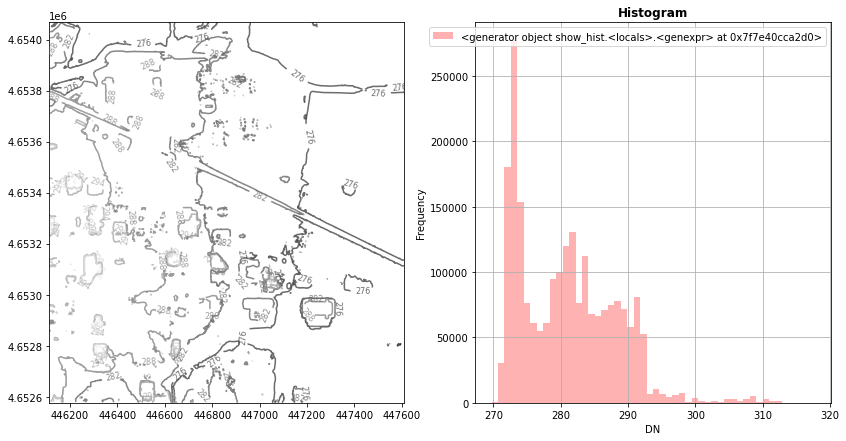

In [10]:
show_raster('../data/iowa.tif')

In [65]:
def plot_3d_map(results):
    """
    plotting of a 3d map
    args: 
        results (list): input a python list of tuples in the form of (X,Y,Z)
    return:
        3d plot of the input points
    """
    # set data        
    X = np.array([x[0] for x in results])
    Y = np.array([x[1] for x in results])
    Z = np.array([x[2] for x in results])

    # plot data
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.set_size_inches(18.5, 10.5, forward=True)
    ax = plt.axes(projection='3d')
    ax.scatter(X, Y, Z, s=0.01,color="green")
    ax.set_xlabel('long')
    ax.set_ylabel('lat')
    ax.set_zlabel('elevation')
    plt.show()


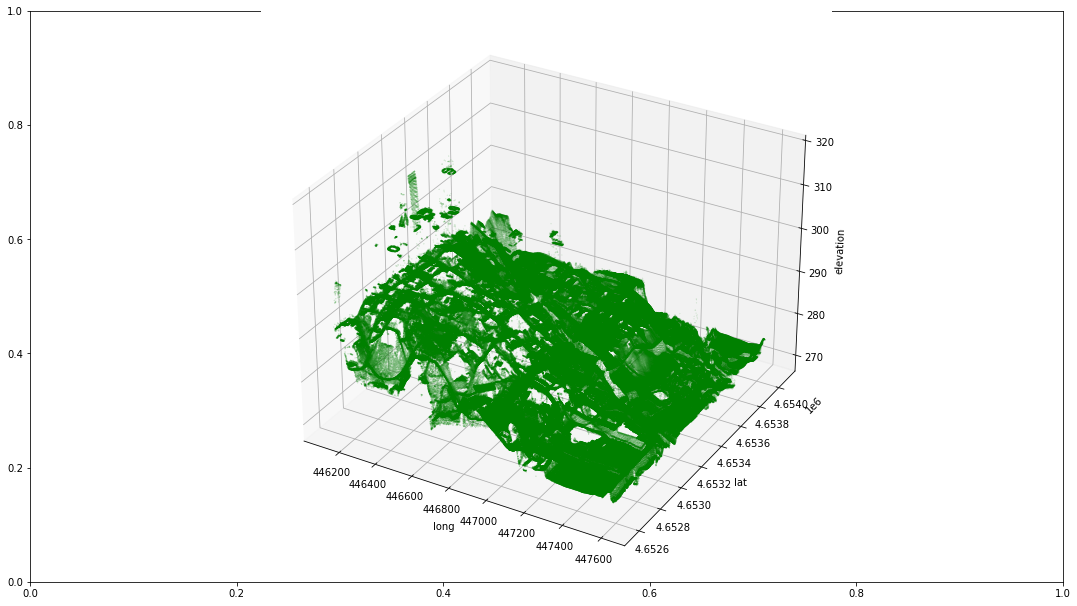

In [66]:
plot_3d_map(results)

In [71]:
def plot_2d_heatmap(df,column,title):
    """
    plot a 2d heat map of the terrain
    args:
        df (geopndas df): a geopandas dataframe demonstrating the data
        column (str): input column to outline in string
        title (str): input title of the map in string
    return:
        2d heat map of terrain
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    df.plot(column=column, ax=ax, legend=True, cmap="terrain")
    plt.title(title)
    plt.xlabel('long')
    plt.ylabel('lat')
    plt.show()

In [ ]:
plot_2d_heatmap(gdf,column='elevation_m',title="Iowa 2d heatmap")